<a href="https://colab.research.google.com/github/silvioraof/NLP_infosec_clustering/blob/main/Complete_Project_InfoSec_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Complete Project InfoSec Clustering

Author: Silvio R. Assunção de Oliveira Filho

Subject: CE-299 AI for Cybersecurity

Aeronautics Institute of Technology - ITA Brazil

##Installing libraries and softwares

In [ ]:
#library and softwares installation (for jupyter notebook)
#!pip install -q scikit-learn
!spacy download pt_core_news_sm
!apt install build-essential libpoppler-cpp-dev pkg-config python3-dev

     |████████████████████████████████| 21.2 MB 1.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
pkg-config is already the newest version (0.29.1-0ubuntu2).
libpoppler-cpp-dev is already the newest version (0.62.0-2ubuntu2.12).
python3-dev is already the newest version (3.6.7-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
!pip install -q PyPdf2 pdftotext 

In [ ]:
import os
import pdftotext
import re
import sys
import nltk
import sklearn
import pandas as pd
import numpy as np
import PyPDF2 as pdf
import spacy
import pt_core_news_sm
import errno
import time
import string
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from collections import Counter
from google.colab import drive
from pandas import Series

from nltk import punkt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.cluster.hierarchy import ward, dendrogram

sp = pt_core_news_sm.load()
nltk.download('punkt')
nltk.download("stopwords")
stop_words_br = set(stopwords.words('portuguese'))

print('Python: {}'.format(sys.version))
print('RE: {}'.format(re.__version__))
print('NLTK: {}'.format(nltk.__version__))
print('Scikit-learn: {}'.format(sklearn.__version__))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Pdf: {}'.format(pdf.__version__))
print('Spacy: {}'.format(spacy.__version__))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Python: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
RE: 2.2.1
NLTK: 3.2.5
Scikit-learn: 1.0.1
Pandas: 1.1.5
Numpy: 1.19.5
Pdf: 1.26.0
Spacy: 2.2.4


##GDrive load

In [ ]:
drive.mount('/datasets/')
os.chdir("/datasets/MyDrive/Datasets/")

Mounted at /datasets/


##Input Data Convert pdf to txt

In [ ]:
#convert to txt and save in txt folder
#function extractor and save
def text_extractor(path, save_path, file):
# Load your PDF
    with open(os.path.join(path,file), "rb") as f:
        pdf = pdftotext.PDF(f)
# creating a text file after iterating through all pages in the pdf
    filename = file.split('.')[0]
    complete_filename = os.path.join(save_path, filename+".txt")
    file = open(complete_filename, "w")
    for page in pdf:
        file.write(page)
    file.close()

#Path definition
path = 'Infosec_pdf_full'
save_path = '/datasets/MyDrive/Datasets/Infosec_txt_full'
if not os.path.exists(os.path.dirname(save_path)):
    try:
        os.makedirs(os.path.dirname(save_path))
    except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise
#List source folder
for file in os.listdir(path):
    if not file.endswith(".pdf"):
        continue
    text_extractor(path, save_path, file)

In [ ]:
path = 'Infosec_pdf_full'
save_path = '/datasets/MyDrive/Datasets/Infosec_txt_full'
os.chdir(save_path)
!ls

OSError: ignored

##Pre-processing
Starting working with files in folder Infosec_txt
text parsed and words extracted 

###Clean_text


In [ ]:

def clean_text(text_complete):
    text = sp(text_complete)
    para_lematizar = ''
    para_lematizar_spacy = ''
    for token in text: 
        para_lematizar_spacy += (token.lemma_ + " ")
        feats = ''
        if token.like_num != True:
            para_lematizar += (
                token.text + "/" +
                token.lemma_ + "/" +
                token.pos_ + "/" +
                "/".join([x.split("=")[1] for x in feats if "=" in x]) + " "
                )
        else:
            para_lematizar += (token.text + " ")
    para_lematizar = para_lematizar.lower()
    # Fixing and splitting contractions of prepositions and determiners
    dos = re.sub(r'\bd(?P<dos>[oa]s?\b)\S+', 'de/de \g<dos>/o', para_lematizar)
    nos = re.sub(r'\bn(?P<nos>[oa]s?\b)\S+', 'em/em \g<nos>/o', dos)
    aos = re.sub(r'\ba(?P<aos>os?\b)\S+', 'a/a \g<aos>/o', nos)
    pelos = re.sub(r'\bpel(?P<pelos>[oa]s?\b)\S+', 'por/por \g<pelos>/o', aos)
    # Fixing two specific words
    suas = re.sub(r'\b(?P<suas>suas?)\S+', '\g<suas>/seu', pelos)
    umas = re.sub(r'\b(?P<umas>umas?)\S+', '\g<umas>/um', suas)
    vou_vamos = re.sub(r'\b(?P<vou>(vou|vamos))\S+', '\g<vou>/ir', umas)
    diga = re.sub(r'\b(?P<diga>diga)\S+', '\g<diga>/dizer', vou_vamos)
    nos = re.sub(r'\b(?P<nós>nós)/\w+\S+', '\g<nós>/nós', diga)
    e_ser = re.sub(r'\b(?P<é>é\b)/\w+\S+', '\g<é>/ser', nos)
    de_pron = re.sub(r'\bd(?P<rad>aquel|es?)(?P<var>[lts]?)(?P<des>[ea]s?)\b\S+',
                    'de/de \g<rad>\g<var>\g<des>/\g<rad>\g<var>e', e_ser)
    de_pron_i = re.sub(r'\bd(?P<rad>aquil|is?)(?P<var>[ts]?)o\b\S+',
                      'de/de \g<rad>\g<var>o/\g<rad>\g<var>o', de_pron)
    em_pron = re.sub(r'\bn(?P<rad>aquel|es?)(?P<var>[lts]?)(?P<des>[ea]s?)\b\S+',
                    'em/em \g<rad>\g<var>\g<des>/\g<rad>\g<var>e', de_pron_i)
    em_pron_i = re.sub(r'\bn(?P<rad>aquil|is?)(?P<var>[ts]?)o\b\S+',
                      'em/em \g<rad>\g<var>o/\g<rad>\g<var>o', em_pron)
    a = re.sub(r'(?P<a>\ba\b)/o/[sa]\S+', '\g<a>/a', em_pron_i)
    à = re.sub(r'(?P<à>\bàs?\b)\S+', '\g<à>/a a/a', a)
    # Fixing issues with closed class words
    final_r = re.sub(r'(?P<pal>\w+)/\w+r/(det|adv|adp|sconj)\S*',
                    '\g<pal>/\g<pal>', à)
    # Consertando número e gênero de adjetivos
    # Fixing number and gender of adjectives
    adj_fp = re.sub(r'(?P<tudo>(?P<rad>\b\w+)as?/adj\S+\b)',
                    '\g<tudo>/\g<rad>o', final_r)
    # Consertando substantivos
    # Fixing nouns
    subs_a = re.sub(r'(?P<tudo>(?P<simples_a>\w+a)s)/\w+r\b/(adj|noun)\S+plur',
                    '\g<tudo>/\g<simples_a>', adj_fp) # empresa, demora mas professora
    subs_r = re.sub(r'(?P<tudo>(?P<simples_r>\w+)es)/\w+r\b/(adj|noun)\S+plur',
                    '\g<tudo>/\g<simples_r>', subs_a) # cor, mar
    subs_l = re.sub(r'(?P<tudo>(?P<simples_l>\w+)is)/\w+r\b/(adj|noun)\S+plur',
                    '\g<tudo>/\g<simples_l>l', subs_r) # portais
    subs_sg = re.sub(r'(?P<simples_sg>\w+[^r])/\w+r\b/(adj|noun)\S+sing',
                    '\g<simples_sg>/\g<simples_sg>', subs_l) # livro, empresa
    subs_ivo = re.sub(r'(?P<tudo>(?P<rad>\w+iv[oa])s?)/\w+/noun\S+',
                      '\g<tudo>/\g<rad>', subs_sg) # alternativas
    subs_ica = re.sub(r'(?P<tudo>(?P<rad>\w+átic[oa])s?)/\w+/noun\S+',
                      '\g<tudo>/\g<rad>', subs_ivo) # problemática
    # Consertando particípios de verbos da 1ª conjugação
    # Fixing participles of verbs from the 1st conjugation
    partic = re.sub(
    r'(?P<tudo>(?P<rad>\w+a)(?P<partic>d[oa]s?))/\w+d[oa]s?/verb\S+',
    r'\g<tudo>/\g<rad>r', subs_ica)
    # Consertando parcialmente particípios de verbos da 2ª e 3ª conjugações(2)
    # Partially fixing participles of verbs from the 2nd and 3rd conjugations(2)
    partic_e = re.sub(
        r'(?P<tudo>(?P<rad>\w+[csho])[ií](?P<partic>d[oa]s?))/\w+d[oa]s?/verb\S+',
        r'\g<tudo>/\g<rad>er', partic)
    partic_i = re.sub(
        r'(?P<tudo>(?P<rad>\w+[anju])[ií](?P<partic>d[oa]s?))/\w+d[oa]s?/verb\S+',
        r'\g<tudo>/\g<rad>ir', partic_e)
    # recebidos --> recebir; os irregulares

    # Consertando parcialmente situações envolvendo clíticos(3)
    # Partially fixing issues with clitics(3)
    clit_a = re.sub(r'(?P<tudo>(?P<pal>\w+)á-(?P<clit>l[oa]s?))\S+',
                    '\g<pal>ar \g<clit>/o', partic_i) # deixá-los
    clit_e = re.sub(r'(?P<tudo>(?P<pal>\w+)ê-(?P<clit>l[oa]s?))\S+',
                    '\g<pal>er \g<clit>/o', clit_a) # fazê-los
    clit_i = re.sub(r'(?P<tudo>(?P<pal>\w+)[ií]-(?P<clit>l[oa]s?))\S+',
                    '\g<pal>ir \g<clit>/o', clit_e) # destruí-los
    clit_r = re.sub(r'(?P<tudo>(?P<pal>\w+r)-(?P<clit>[mtsnvl]\w{,3})(-\w+)?)\S+',
                    '\g<pal> \g<clit>/\g<clit>',
                    clit_i) # fazer-me, discutir-se-á
    # casos com lhe, n[oa]s? são possíveis mas podem ter problemas (Contem-nos a verdade! x Recebem-nos bem, imperativo...)
    # clit_r: irregulares (fizer-me), tem que lematizar...; mesóclise apenas se o radical terminar em 'r' e a mesma observação sobre irregularidade
    # Consertando verbos irregulares com passiva sintética
    # Fixing irregular verbs with synthetic passive
    se_irr_1 = re.sub(r'(?P<tudo>(?P<cs>\b[cs])(a|ou)b\w+)-se\S+',
                      '\g<cs>aber se/se', clit_r)
    se_irr_2 = re.sub(r'(?P<tudo>(?P<ter>\w*t)[eéêi]\w+)-se\S+',
                      '\g<ter>er se/se', se_irr_1)
    se_irr_3 = re.sub(r'(?P<tudo>(?P<ver>(\b(ante|p?re|entre)?v))[iêe]\w+\b)-se\S+',
                      '\g<ver>er se/se', se_irr_2)
    se_irr_4 = re.sub(r'(?P<tudo>(?P<por>\w*p)[õôu]\w+)-se\S+',
                      '\g<por>or se/se', se_irr_3)
    se_irr_5 = re.sub(
        r'(?P<tudo>(?P<vir>(\b(ad|inter|entre|sobre)?v))[iéêe]\w+\b)-se\S+',
        '\g<vir>ir se/se', se_irr_4)
    se_irr_6 = re.sub(r'(?P<tudo>(?P<fazer>\w*f)[aei]z[ei]?(r?a)?m?)-se\S+',
                      '\g<fazer>azer se/se', se_irr_5)
    se_irr_7 = re.sub(r'(?P<tudo>(?P<dizer>\w*d)i[zs]s?[ei]?(r?a)?m?)-se\S+',
                      '\g<dizer>izer se/se', se_irr_6)
    se_irr_8 = re.sub(r'(?P<tudo>(?P<querer>\bqu)[ei][rs][ei]?(r?a)?m?)-se\S+',
                      '\g<querer>erer se/se', se_irr_7)
    se_irr_9 = re.sub(r'(?P<tudo>(?P<dar>\bd)[eaáã][uorv]?(am?)?)-se\S+',
                      '\g<dar>ar se/se', se_irr_8)
    se_irr_x = re.sub(r'(?P<tudo>\bfo(i|ram))-se\S+',
                      'ser se/se', se_irr_9) # assumindo 'ser', não 'ir'
    # Consertando parcialmente passiva sintética com verbos da 1ª-2ª conjugações(4)
    # Partially fixing synthetic passive with verbs of the 1st-2nd conjugations(4)
    se_reg = re.sub(r'(?P<tudo>(?P<rad>\w+[ea])m?-se\b)\S+',
                    '\g<tudo>/\g<rad>r se/se', se_irr_x) #'e': infere-se -> inferer
    # Limitações do 'a': lava-se x falava-se - falavar; cantaram-se x comemoram-se

    # Eliminando a duplicação (misteriosa!) de 'se' em irregulares no plural
    # Eliminating the (mysterious!) duplication of 'se' in plural irregular verbs
    se_se = re.sub(r'(?P<se>\sse/se){2}', '\g<se>', se_reg)

    # Removendo as postags e as features das tags remanescentes
    # Removing the remaining postags and tag features
    final_final = re.sub(r'(?P<pal_lema>[a-zA-Zá-úÁ-Ú]+(-[a-zA-Zá-úÁ-Ú]+)*/[a-zA-Zá-úÁ-Ú]+(-[a-zA-Zá-úÁ-Ú]+)*)/\S*',
                        '\g<pal_lema>', se_se)
    # Removendo palavras e pontuação para gerar apenas os lemas
    # Removing words and punctuation to generate only the lemmas
    so_lemas = re.sub(r'[a-zA-Zá-úÁ-Ú]+/(?P<lema>[a-zA-Zá-úÁ-Ú]+)', '\g<lema>', final_final)
    so_lemas = re.sub(r'\./\./punct/', '.', so_lemas)
    so_lemas = re.sub(r'\S+punct/', '', so_lemas)
    so_lemas = re.sub(r'/\S*', '', so_lemas)
    sem_data = re.sub(r'[0-9]{2}/[0-9]{2}/[0-9]{4}', 'data', so_lemas)
    sem_data2 = re.sub(r'janeiro', '', sem_data)
    sem_data2 = re.sub(r'fevereiro', '', sem_data2)
    sem_data2 = re.sub(r'março', '', sem_data2)
    sem_data2 = re.sub(r'abril', '', sem_data2)
    sem_data2 = re.sub(r'maio', '', sem_data2)
    sem_data2 = re.sub(r'junho', '', sem_data2)
    sem_data2 = re.sub(r'julho', '', sem_data2)
    sem_data2 = re.sub(r'agosto', '', sem_data2)
    sem_data2 = re.sub(r'setembro', '', sem_data2)
    sem_data2 = re.sub(r'outubro', '', sem_data2)
    sem_data2 = re.sub(r'novembro', '', sem_data2)
    sem_data2 = re.sub(r'dezembro', '', sem_data2)
    so_lemas2 = re.sub(r'\n', '', sem_data2)
    so_lemas3 = re.sub(r'[^\w]', ' ', so_lemas2)
    so_lemas4 = re.sub(r'_', '', so_lemas3)
    so_lemas5 = re.sub(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress', so_lemas4)
    so_lemas6 = re.sub(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress', so_lemas5)
    so_lemas7 = re.sub(r'\d+(\.\d+)?', '', so_lemas6)
    so_lemas8 = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', so_lemas7)
    so_lemas9 = re.sub(r"\b\d+\b *|\b[a-z]\b *","", so_lemas8)
    so_lemas10 = re.sub(r' +', ' ', so_lemas9)
    so_lemas11 = re.sub(r'página', ' ', so_lemas10)
    so_lemas12 = re.sub(r'pag ', ' ', so_lemas11)
    #correcting 'devir' to 'dever'
    versao_corrigida1 = re.sub(r'devir', 'dever', so_lemas12)
    #versao_corrigida
    return versao_corrigida1

##Working
Extract name sector and isPolicy and then clean_text (stopwords, lemma etc)

In [ ]:
#Name and sector and isPolicy extract (working)
data = []
for file in os.listdir(save_path):
    if not file.endswith(".txt"):
        continue
    my_text = open(file, 'r')
    if file.split('-')[0] == 'infosec':
      is_policy = True
    else:
      is_policy = False
    name_list = file.split('.')[0]
    name = name_list.split("setor-",1)[0]
    setor = name_list.split("setor-",1)[1]
    name_index = name_list.split('-setor')[0]
    name_index = name_index.split('-')[1]
    data.append([name_index, is_policy, str(setor), clean_text(my_text.read())])

df = pd.DataFrame(data, columns=['index', 'isPol', 'SECTOR', 'text'])
df.set_index('index', inplace=True)

###Convert sector to category

In [ ]:
df

,isPol,SECTOR,text
index,,,
fidd,True,bancario,política de segurança de informação segurança ...
necton,True,bancario,manual de sistema de controles internos mci a...
fatec,False,academico,politíca de segurança de informação em empres...
fab,True,militar,ministério de defesa comando de aeronáutica p...
sebrae,True,governo,índice objetivo declaração de comprometimento ...
diefra,True,privado,diefra engenharia consultoria ltda política d...
rodobens,True,privado,política de segurança cibernética esta políti...
senac,True,governo,psi política de segurança de informação docume...
fiocruz,True,saude,política de segurança de informação comunicaç...


In [ ]:
df['SECTOR'] = df['SECTOR'].astype("category")

In [ ]:
#check dataframe
#list by sector 
df.groupby('SECTOR').count()

,isPol,text
SECTOR,,
academico,9,9
bancario,12,12
governo,12,12
militar,5,5
privado,5,5
saude,2,2


In [ ]:
#list by isPolicy
df.groupby('isPol').count()

,SECTOR,text
isPol,,
False,11,11
True,34,34


In [ ]:
df.head()

,isPol,SECTOR,text
index,,,
fidd,True,bancario,política de segurança de informação segurança ...
necton,True,bancario,manual de sistema de controles internos mci a...
fatec,False,academico,politíca de segurança de informação em empres...
fab,True,militar,ministério de defesa comando de aeronáutica p...
sebrae,True,governo,índice objetivo declaração de comprometimento ...


In [ ]:
#apply remove stopwords again
df['text'] = df['text'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words_br))
print(df['SECTOR'][:30])
df.head()

index
fidd              bancario
necton            bancario
fatec            academico
fab                militar
sebrae             governo
diefra             privado
rodobens           privado
senac              governo
fiocruz              saude
pnsefpub           governo
judiciario         governo
pnd_md             militar
estado_sp          governo
mirae             bancario
nic_br             governo
raizen             privado
ufpb             academico
ghc                  saude
ufgd             academico
banco_china       bancario
ufmt             academico
banco_paccar      bancario
banco_alpha       bancario
banco_itau        bancario
ufsca            academico
fab_dcta           militar
banco_luso        bancario
fab_decea          militar
banco_cargill     bancario
consfedquim        governo
Name: SECTOR, dtype: category
Categories (6, object): ['academico', 'bancario', 'governo', 'militar', 'privado', 'saude']


,isPol,SECTOR,text
index,,,
fidd,True,bancario,política segurança informação segurança cibern...
necton,True,bancario,manual sistema controles internos mci assunto ...
fatec,False,academico,politíca segurança informação empresas fabio e...
fab,True,militar,ministério defesa comando aeronáutica política...
sebrae,True,governo,índice objetivo declaração comprometimento apl...


##STEMMING
"Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even  if the stem itself is not a valid word in the Language."

In [ ]:
#"Stemming is the process of reducing inflection in words to their root forms 
#such as mapping a group of words to the same stem even 
#if the stem itself is not a valid word in the Language."
stemmer = SnowballStemmer("portuguese")

def tokenize_and_stem(text):
    """This Function recieves a string, then tokenize and stem all words in the string
    Keyword arguments:
    text -- the string containing the target text
    """
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(
        text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [ ]:
def tokenize_only(text):
    """This Function opens the dataset file, and ONLY tokenize the words
    Keyword arguments:
    text -- contains the target text
    """
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text)
              for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

##Creating VocabFrame
Bag-of-words

Could be useful after

ref:[https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/]

---



In [ ]:
totalvocab_stemmed = []
totalvocab_tokenized = []

# Process text to be ready for clustering. Processing include: removing punctutaion, stopwords, stemming, tokenizing
for i in df['text']:
    replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    i = i.translate(replace_punctuation)

    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

    
vocab_frame = pd.DataFrame(
    {'words': totalvocab_tokenized}, index=totalvocab_stemmed)


print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 300501 items in vocab_frame


In [ ]:
print(vocab_frame.head(20))

                      words
polít              política
segur             segurança
inform           informação
segur             segurança
cibernét        cibernética
sumári              sumário
introdu          introdução
públic              público
alvo                   alvo
revisã              revisão
atualiz         atualização
respons    responsabilidade
objet             objetivos
princípi         princípios
objet             objetivos
princípi         princípios
dev                 deveres
respons   responsabilidades
respons   responsabilidades
gestor             gestores


In [ ]:
# index remove duplicate
vocab_frame = vocab_frame.drop_duplicates()

In [ ]:
#DF info
print(vocab_frame)
print("\n\n*************** Info *************\n")
df.info()
print("\n\n*************** df.head **********\n")
df.head()

                       words
polít               política
segur              segurança
inform            informação
cibernét         cibernética
sumári               sumário
...                      ...
pen                   penais
bols                   bolsa
penitenciári  penitenciários
ms                        ms
transferent   transferências

[18420 rows x 1 columns]


*************** Info *************

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, fidd to polpub
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   isPol       45 non-null     bool    
 1   SECTOR      45 non-null     category
 2   text        45 non-null     object  
 3   clusters    45 non-null     int32   
 4   My_labeled  45 non-null     object  
 5   label       45 non-null     category
dtypes: bool(1), category(2), int32(1), object(2)
memory usage: 3.0+ KB


*************** df.head **********



,isPol,SECTOR,text,clusters,My_labeled,label
index,,,,,,
fidd,True,bancario,política segurança informação segurança cibern...,0,bancario,bancario
necton,True,bancario,manual sistema controles internos mci assunto ...,0,bancario,bancario
fatec,False,academico,politíca segurança informação empresas fabio e...,4,privado,academico
fab,True,militar,ministério defesa comando aeronáutica política...,5,academico,militar
sebrae,True,governo,índice objetivo declaração comprometimento apl...,3,saude,governo


#Document Vectorization


In [ ]:
tfidf_vectorizer = TfidfVectorizer(
                                   max_df=0.80, #remove 20% most common
                                   max_features=200, 
                                   min_df=0.20, #remove 20% less common
                                   use_idf=True, 
                                   tokenizer=tokenize_and_stem, 
                                   ngram_range=(1, 4) #create up to 4 gram
                                   )

tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])
tfidf_matrix

<45x200 sparse matrix of type '<class 'numpy.float64'>'
	with 5603 stored elements in Compressed Sparse Row format>

In [ ]:
print(tfidf_matrix[:20,])

  (0, 132)	0.24575313811714192
  (0, 166)	0.07181135373167963
  (0, 178)	0.04822379947924776
  (0, 163)	0.3657704389962569
  (0, 62)	0.010521271811461529
  (0, 19)	0.007508840824449486
  (0, 12)	0.008617818806367888
  (0, 11)	0.0216179924475996
  (0, 186)	0.01644905544551756
  (0, 141)	0.025853456419103665
  (0, 147)	0.007342712073741679
  (0, 5)	0.016835790463241972
  (0, 193)	0.01535957113232137
  (0, 47)	0.010521271811461529
  (0, 31)	0.009039225226454214
  (0, 143)	0.007855833882968349
  (0, 179)	0.036713560368708396
  (0, 137)	0.009039225226454214
  (0, 3)	0.0071811353731679635
  (0, 45)	0.017235637612735777
  (0, 6)	0.05744908298534371
  (0, 125)	0.009039225226454214
  (0, 41)	0.014362270746335927
  (0, 140)	0.009039225226454214
  (0, 0)	0.00822452772275878
  :	:
  (19, 9)	0.010663271981942394
  (19, 13)	0.020384548139137378
  (19, 142)	0.042653087927769576
  (19, 118)	0.021819176996801512
  (19, 80)	0.08772710916192791
  (19, 51)	0.06254585583779466
  (19, 24)	0.0199335518275533

In [ ]:
feature_names2 = tfidf_vectorizer.get_feature_names()
first_document_vector = tfidf_matrix[0,:]
df2 = pd.DataFrame(first_document_vector.T.todense(), index=feature_names2, columns=['tfidf']) 
df2.sort_values(by=['tfidf'],ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
diretor,0.391669
segur cibernét,0.365770
cibernét,0.329498
ir,0.250068
polít segur inform,0.245753
...,...
crim,0.000000
human,0.000000
forc,0.000000
cooper,0.000000


https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.YZPM7nvMLeQ

In [ ]:
terms =  tfidf_vectorizer.get_feature_names_out()
print("# of terms:" + str(len(terms)))
print(terms[:20])

# of terms:200
['aceit' 'aind' 'algum' 'além' 'and' 'ano' 'anális' 'apen' 'apresent'
 'arquiv' 'assunt' 'atac' 'ataqu' 'atend' 'ator' 'através' 'auditor'
 'aument' 'autor' 'açã']


Silhouette score

For n_clusters = 2, 	 the avg silhouette score is 0.11498314066421683)
For n_clusters = 3, 	 the avg silhouette score is 0.11776223518706529)
For n_clusters = 4, 	 the avg silhouette score is 0.10160460287589973)
For n_clusters = 5, 	 the avg silhouette score is 0.08670382283852607)
For n_clusters = 6, 	 the avg silhouette score is 0.11004399594640574)
For n_clusters = 7, 	 the avg silhouette score is 0.09244958509188)
For n_clusters = 8, 	 the avg silhouette score is 0.09115534435122465)
For n_clusters = 9, 	 the avg silhouette score is 0.10869291217474779)
For n_clusters = 10, 	 the avg silhouette score is 0.06499584290094645)
For n_clusters = 11, 	 the avg silhouette score is 0.05560181632242638)




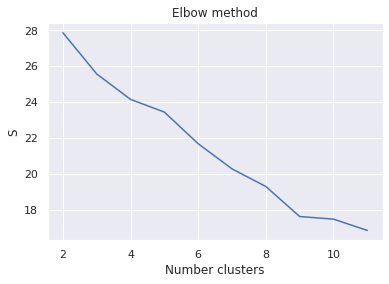

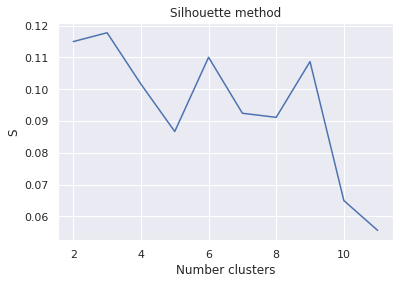

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

wcss = [] 
score = []
print("Silhouette score\n")
for i in range(2, 12):
  km = KMeans(n_clusters=i, 
              init='random',
              max_iter=300, 
              n_init=1, 
              algorithm='auto',
              random_state=0)
  km.fit(tfidf_matrix)
  wcss.append(km.inertia_)
  preds = km.fit_predict(tfidf_matrix)
  sc = silhouette_score (tfidf_matrix, preds, metric='euclidean')
  score.append(sc)
  print("For n_clusters = {}, \t the avg silhouette score is {})".format(i, sc))
print("\n")
plt.plot(range(2, 12), wcss)
plt.ylabel('WCSS')
#plt.plot(range(2,14), score)
#plt.ylabel('SCORE')
plt.title('Elbow method')
plt.xlabel('Number clusters')
plt.ylabel('S')
plt.show()
print('\n')
plt.plot(range(2, 12), score)
plt.ylabel('SCORE')
#plt.plot(range(2,14), score)
#plt.ylabel('SCORE')
plt.title('Silhouette method')
plt.xlabel('Number clusters')
plt.ylabel('S')
plt.show()

##Clusterization 

In [ ]:
num_clusters = 6
k_means = KMeans(n_clusters=num_clusters, init='random', max_iter=300, n_init=1, random_state=0)
k_means.fit(tfidf_matrix)
clusters2 = k_means.fit_predict(tfidf_matrix)

score = silhouette_score (tfidf_matrix, clusters2, metric='euclidean')
print("For n_clusters = {}, the avg silhouette score is {})".format(num_clusters, score))

For n_clusters = 6, the avg silhouette score is 0.11004399594640574)


In [ ]:
#from sklearn.metrics import silhouette_samples, silhouette_score
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(tfidf_matrix, clusters2)
silhouette_avg = score
y_lower = 10

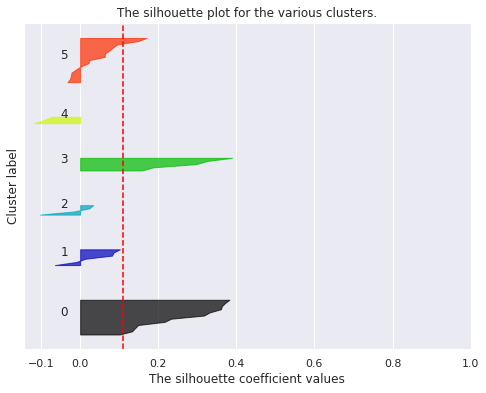

In [ ]:
import matplotlib.cm as cm
fig, (ax1) = plt.subplots(1, 1, sharex=True, figsize=(8, 6))

n_clusters = num_clusters
cluster_labels = clusters2
X = tfidf_matrix[0]

for i in range(num_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[clusters2 == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

        # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


plt.show()

In [ ]:
df.head()

,isPol,SECTOR,text
index,,,
fidd,True,bancario,política segurança informação segurança cibern...
necton,True,bancario,manual sistema controles internos mci assunto ...
fatec,False,academico,politíca segurança informação empresas fabio e...
fab,True,militar,ministério defesa comando aeronáutica política...
sebrae,True,governo,índice objetivo declaração comprometimento apl...


***********************************************
Top terms per cluster:
***********************************************

Cluster 0 words: b'cibern\xc3\xa9tica', b'seguran\xc3\xa7a', b'banco', b'neg\xc3\xb3cio', b'pol\xc3\xadtica', b'diretoria', b'grupo', b'computador', b'vulnerabilidades', b'cooperar', b'resposta', b'terceiro',

Cluster 1 words: b'viol\xc3\xaancia', b'propn', b'precisar', b'noun', b'estado', b'sociedade', b'social', b'the', b'haver', b'direitos', b'cibern\xc3\xa9tica', b'paulo',

Cluster 2 words: b'nacional', b'pol\xc3\xadtica', b'defeso', b'\xc3\xa2mbito', b'minist\xc3\xa9rio', b'espa\xc3\xa7o', b'diretoria', b'departamento', b'coordenar', b'militares', b'force', b'estrat\xc3\xa9gia',

Cluster 3 words: b'seguran\xc3\xa7a', b'informa\xc3\xa7\xc3\xa3o', b'n\xc2\xba', b'tecnologia', b'institucional', b'pol\xc3\xadtica', b'gestores', b'comit\xc3\xaa', b'federal', b'\xc3\xb3rg\xc3\xa3o', b'\xc3\xa2mbito', b'minist\xc3\xa9rio',

Cluster 4 words: b'http', b'empresas', b'feder

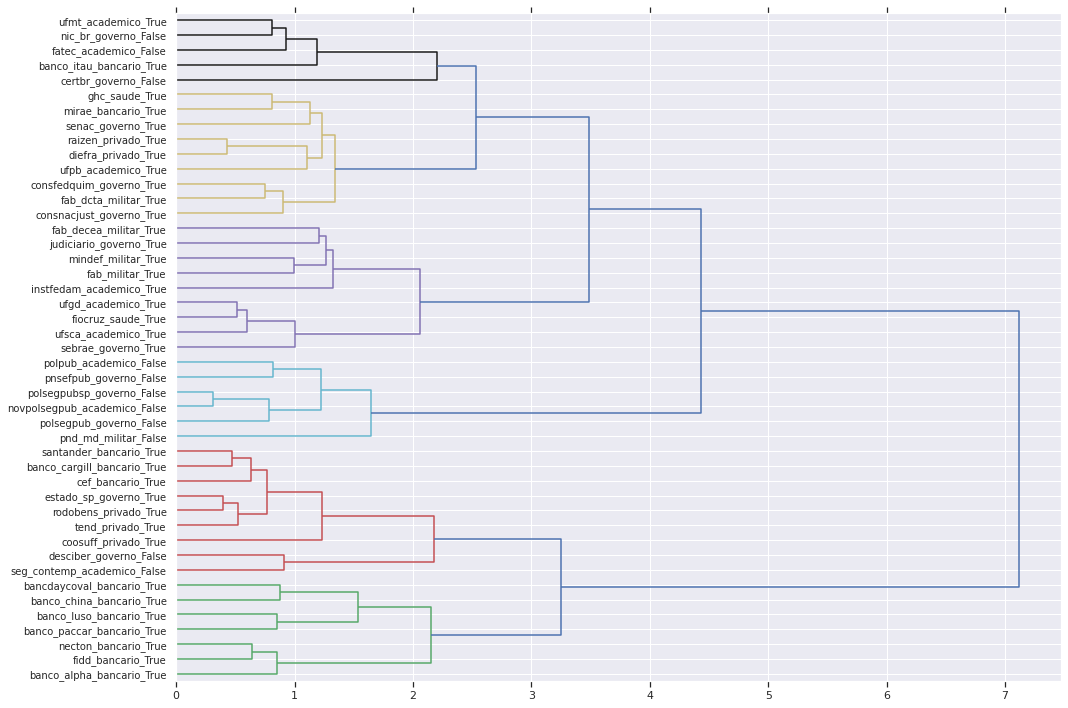

In [ ]:
    order_centroids = k_means.cluster_centers_.argsort()[:, ::-1]
    dist = 1 - cosine_similarity(tfidf_matrix)

    print('***********************************************')
    print("Top terms per cluster:")
    print('***********************************************')
    print()
    for i in range(num_clusters):
        print("Cluster %d words:" % i, end='')

        for ind in order_centroids[i, :12]:  # replace 6 with n words per cluster
            print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[
                  0][0].encode('utf-8'), end=',')
        print()  # add whitespace
        print()  # add whitespace


    #define the linkage_matrix using ward clustering pre-computed distances
    linkage_matrix = ward(dist) 
    label_conc = df.index+'_'+df['SECTOR'].astype(str)+'_'+df['isPol'].astype(str)
    # Plot the dendogram showing hierirical similarity 
    fig, ax = plt.subplots(figsize=(15, 10)) # set size
    ax = dendrogram(linkage_matrix, orientation="right", labels= label_conc, leaf_font_size=10, color_threshold=2.5)
    plt.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    plt.tight_layout() #show plot with tight layout

    #uncomment below to save figure
    #plt.savefig('ward_clusters_new.png', dpi=300) #save figure as ward_clusters

In [ ]:
order_centroids

array([[ 29, 163,  20, ..., 131, 191, 195],
       [195, 144, 135, ...,  16, 164, 132],
       [111, 132,  44, ..., 120,  20, 126],
       [164,  92, 116, ..., 107,  90,  47],
       [ 88,  60,  75, ...,  27,  28,  49],
       [185, 132,  60, ..., 131, 195,  14]])

In [ ]:
df.head()

,isPol,SECTOR,text,clusters
index,,,,
fidd,True,bancario,política segurança informação segurança cibern...,0
necton,True,bancario,manual sistema controles internos mci assunto ...,0
fatec,False,academico,politíca segurança informação empresas fabio e...,4
fab,True,militar,ministério defesa comando aeronáutica política...,5
sebrae,True,governo,índice objetivo declaração comprometimento apl...,3


In [ ]:
#Create pred cluster column
df['clusters'] = k_means.labels_
df

,isPol,SECTOR,text,clusters
index,,,,
fidd,True,bancario,política segurança informação segurança cibern...,0
necton,True,bancario,manual sistema controles internos mci assunto ...,0
fatec,False,academico,politíca segurança informação empresas fabio e...,4
fab,True,militar,ministério defesa comando aeronáutica política...,5
sebrae,True,governo,índice objetivo declaração comprometimento apl...,3
diefra,True,privado,diefra engenharia consultoria ltda política se...,5
rodobens,True,privado,política segurança cibernética política segura...,0
senac,True,governo,psi política segurança informação documento di...,5
fiocruz,True,saude,política segurança informação comunicações pos...,3


In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

y_true = pd.factorize(df['SECTOR'])[0]
#print(df['SECTOR'], y_true)

y_pred = df['clusters']

cm = confusion_matrix(y_true, y_pred)

score = round(accuracy_score(y_pred, y_true), 4)
print('Accuracy scored using k-means clustering: ', score)

Accuracy scored using k-means clustering:  0.2667


In [ ]:
#sort by sector frequency
df.groupby('SECTOR').count().sort_values('clusters', ascending=False)

,isPol,text,clusters
SECTOR,,,
bancario,12,12,12
governo,12,12,12
academico,9,9,9
militar,5,5,5
privado,5,5,5
saude,2,2,2


In [ ]:
df.groupby('clusters').count().sort_values('clusters', ascending=True)

,isPol,SECTOR,text
clusters,,,
0,12,12,12
1,6,6,6
2,4,4,4
3,5,5,5
4,3,3,3
5,15,15,15


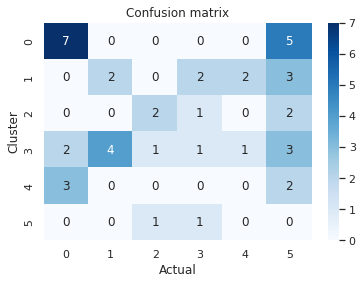

In [ ]:
import seaborn as sns; sns.set()

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion matrix") 

plt.xlabel("Actual") 
plt.ylabel("Cluster") 

plt.show()

Compute accuracy
The accuracy is the sum of the diagonal elements divided by the number of samples:

In [ ]:
 order_centroids = k_means.cluster_centers_.argsort()[:, ::-1]
 for i in range(6):
     print("Cluster %d:\n" % i, end='')
     for ind in order_centroids[i, :12]:
         print(' %s ' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8'), end=' ')
         print()

Cluster 0:
 b'cibern\xc3\xa9tica'  
 b'seguran\xc3\xa7a'  
 b'banco'  
 b'neg\xc3\xb3cio'  
 b'pol\xc3\xadtica'  
 b'diretoria'  
 b'grupo'  
 b'computador'  
 b'vulnerabilidades'  
 b'cooperar'  
 b'resposta'  
 b'terceiro'  
Cluster 1:
 b'viol\xc3\xaancia'  
 b'propn'  
 b'precisar'  
 b'noun'  
 b'estado'  
 b'sociedade'  
 b'social'  
 b'the'  
 b'haver'  
 b'direitos'  
 b'cibern\xc3\xa9tica'  
 b'paulo'  
Cluster 2:
 b'nacional'  
 b'pol\xc3\xadtica'  
 b'defeso'  
 b'\xc3\xa2mbito'  
 b'minist\xc3\xa9rio'  
 b'espa\xc3\xa7o'  
 b'diretoria'  
 b'departamento'  
 b'coordenar'  
 b'militares'  
 b'force'  
 b'estrat\xc3\xa9gia'  
Cluster 3:
 b'seguran\xc3\xa7a'  
 b'informa\xc3\xa7\xc3\xa3o'  
 b'n\xc2\xba'  
 b'tecnologia'  
 b'institucional'  
 b'pol\xc3\xadtica'  
 b'gestores'  
 b'comit\xc3\xaa'  
 b'federal'  
 b'\xc3\xb3rg\xc3\xa3o'  
 b'\xc3\xa2mbito'  
 b'minist\xc3\xa9rio'  
Cluster 4:
 b'http'  
 b'empresas'  
 b'federal'  
 b'governan\xc3\xa7a'  
 b'dispon\xc3\xadvel'  

##Labelling the clusters

In [ ]:
df

,isPol,SECTOR,text,clusters,My_labeled,label
index,,,,,,
fidd,True,bancario,política segurança informação segurança cibern...,0,privado,bancario
necton,True,bancario,manual sistema controles internos mci assunto ...,0,privado,bancario
fatec,False,academico,politíca segurança informação empresas fabio e...,4,academico,academico
fab,True,militar,ministério defesa comando aeronáutica política...,5,saude,militar
sebrae,True,governo,índice objetivo declaração comprometimento apl...,3,bancario,governo
diefra,True,privado,diefra engenharia consultoria ltda política se...,5,saude,privado
rodobens,True,privado,política segurança cibernética política segura...,0,privado,privado
senac,True,governo,psi política segurança informação documento di...,5,saude,governo
fiocruz,True,saude,política segurança informação comunicações pos...,3,bancario,saude


In [ ]:
df_confusion = pd.crosstab(df['SECTOR'], df['clusters'])
df_confusion

clusters,0,1,2,3,4,5
SECTOR,,,,,,
academico,0,2,0,2,2,3
bancario,7,0,0,0,0,5
governo,2,4,1,1,1,3
militar,0,0,2,1,0,2
privado,3,0,0,0,0,2
saude,0,0,1,1,0,0


In [ ]:
df['My_labeled'] = df['clusters']

df['My_labeled'] = df['My_labeled'].replace(5, 'academico')
df['My_labeled'] = df['My_labeled'].replace(0, 'bancario')
df['My_labeled'] = df['My_labeled'].replace(1, 'governo')
df['My_labeled'] = df['My_labeled'].replace(2, 'militar')
df['My_labeled'] = df['My_labeled'].replace(4, 'privado')
df['My_labeled'] = df['My_labeled'].replace(3, 'saude')

df['label'] = df['SECTOR']

In [ ]:
df_confusion2 = pd.crosstab(df['SECTOR'], df['My_labeled'])
df_confusion2

My_labeled,academico,bancario,governo,militar,privado,saude
SECTOR,,,,,,
academico,3,0,2,0,2,2
bancario,5,7,0,0,0,0
governo,3,2,4,1,1,1
militar,2,0,0,2,0,1
privado,2,3,0,0,0,0
saude,0,0,0,1,0,1


##METRICS

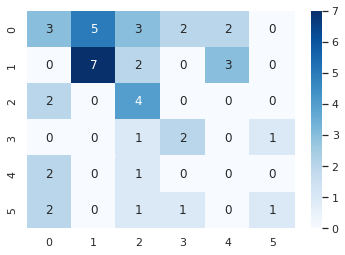

In [ ]:
#Confusion Matrix
y_pred2 = df['My_labeled']
y_true2 = df['label']
c_matrix2 = confusion_matrix(y_pred2, y_true2)
sns.heatmap(c_matrix2, annot=True, fmt="d", cmap="Blues")
plt.show()

In [ ]:
print(accuracy_score(y_true2, y_pred2))

0.37777777777777777
